In [2]:
import random
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import matplotlib
import cv2
import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
from tensorflow.keras import mixed_precision
import keras.backend as K

# set the random seed:
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

DATASET_DIR = '/kaggle/input/pastis-dataset-ddp/PASTIS/'

class Singleton(type):
    _instances = {}

    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton, cls).__call__(*args, **kwargs)
        return cls._instances[cls]

class Metadata(metaclass=Singleton):
    def __init__(self):
        self.dataset_dir = DATASET_DIR
        self._metadata = self._load_metadata_dataframe()
        self._norm_metadata = self._load_norm_metadata()

    @property
    def metadata(self):
        return self._metadata

    @property
    def norm_metadata(self):
        return self._norm_metadata

    def _load_norm_metadata(self):
        return pd.read_json(os.path.join(self.dataset_dir, "NORM_S2_patch.json")).to_dict()

    def _load_metadata_dataframe(self):
        """
        Processing patch metadata and extracting the following features:
        Patch_path, Fold, Patch_id, N_parcel, Parcel_cover, Tile, i_date (date of time series object {i})
        :return: pandas dataframe with metadata of Sentinel-2 patches.
        """
        with open(os.path.join(self.dataset_dir, 'metadata.geojson')) as f:
            metadata = json.load(f)
            metadata = pd.json_normalize(metadata, record_path='features', max_level=1)

        # Processing dates
        dates = pd.DataFrame(metadata['properties.dates-S2'].values.tolist())
        for column in dates.columns:
            d = dates[column]
            dates[f'{column}_date'] = pd.to_datetime(d, format='%Y%m%d')
            dates.drop(columns=[column], inplace=True)

        metadata['Semantic_segmentation_path'] = metadata['properties.ID_PATCH'].apply(lambda x: f'{DATASET_DIR}ANNOTATIONS/TARGET_{x}.npy')
        metadata['Patch_path'] = metadata['properties.ID_PATCH'].apply(lambda x: f'{DATASET_DIR}DATA_S2/S2_{x}.npy')
        metadata.drop(
            columns=['id', 'type', 'properties.id', 'geometry.type', 'geometry.coordinates', 'properties.dates-S2'],
            inplace=True)
        metadata.rename(
            columns={'properties.Fold': 'Fold', 'properties.N_Parcel': 'N_parcel', 'properties.ID_PATCH': 'Patch_id',
                     'properties.Parcel_Cover': 'Parcel_cover', 'properties.TILE': 'Tile'}, inplace=True)

        patches_metadata = pd.concat([metadata, dates], ignore_index=False, axis=1)
        patches_metadata.set_index('Patch_path', inplace=True)

        return patches_metadata

patches_metadata = Metadata().metadata
patches_metadata



2026-01-18 17:16:53.794518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768756613.951090      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768756613.995855      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768756614.368505      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768756614.368538      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768756614.368540      55 computation_placer.cc:177] computation placer alr

,Fold,Patch_id,N_parcel,Parcel_cover,Tile,Semantic_segmentation_path,0_date,1_date,2_date,3_date,...,51_date,52_date,53_date,54_date,55_date,56_date,57_date,58_date,59_date,60_date
Patch_path,,,,,,,,,,,,,,,,,,,,,
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10000.npy,1,10000,119,0.808032,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10001.npy,2,10001,111,0.501986,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10002.npy,4,10002,131,0.638722,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10003.npy,5,10003,75,0.866824,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10004.npy,4,10004,46,0.204906,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_40558.npy,2,40558,33,0.783991,t32ulu,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-17,2018-09-22,2018-09-27,2018-10-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_40559.npy,5,40559,24,0.129896,t32ulu,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-17,2018-09-22,2018-09-27,2018-10-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_40560.npy,3,40560,7,0.255358,t32ulu,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-17,2018-09-22,2018-09-27,2018-10-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [3]:
train_img_list=(list((patches_metadata[patches_metadata['Fold'].isin([1])].index)))
paths_masks=[]
for path in train_img_list:
    paths_masks.append(patches_metadata.loc[path]['Semantic_segmentation_path'])
train_mask_list = paths_masks

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random


In [5]:
class BASTISDatasetTemporal(Dataset):
    def __init__(self, img_files, label_files,
                 crop_size=(64,64),
                 sample_T=38,
                 select_C=list(range(10)),
                 mean=None, std=None):
        
        self.img_files = img_files
        self.label_files = label_files
        self.crop_size = crop_size
        self.sample_T = sample_T
        self.select_C = select_C
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        data = np.load(self.img_files[idx]).astype(np.float32)
        labels = np.load(self.label_files[idx])

        if labels.ndim == 3:
            labels = labels[0]

        T, C, H, W = data.shape

        # Temporal sampling
        if T >= self.sample_T:
            indices = np.linspace(0, T-1, self.sample_T)
            indices = np.round(indices).astype(int)
            data = data[indices]
        else:
            repeat = self.sample_T - T
            data = np.concatenate([data, np.tile(data[-1:], (repeat,1,1,1))], axis=0)

        # Select channels
        data = data[:, self.select_C]

        # Crop
        crop_h, crop_w = self.crop_size
        h_start = random.randint(0, H - crop_h) if H > crop_h else 0
        w_start = random.randint(0, W - crop_w) if W > crop_w else 0

        data = data[:, :, h_start:h_start+crop_h, w_start:w_start+crop_w]
        labels = labels[h_start:h_start+crop_h, w_start:w_start+crop_w]

        data = data / 255.0

        if self.mean is not None:
            m = np.array(self.mean).reshape(1, len(self.select_C), 1, 1)
            s = np.array(self.std).reshape(1, len(self.select_C), 1, 1)
            data = (data - m) / s

        return torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)


In [16]:
def compute_mean_std(img_files, select_C=list(range(10))):
    mean = np.zeros(len(select_C))
    std = np.zeros(len(select_C))
    n = 0

    print("Computing mean/std...")

    for f in img_files:
        data = np.load(f).astype(np.float32)
        data = data[:, select_C] / 255.0
        T, C, H, W = data.shape
        data = data.reshape(T, C, -1)
        mean += data.mean(axis=(0,2))
        std += data.std(axis=(0,2))
        n += 1

    mean /= n
    std /= n
    print("Mean:", mean)
    print("Std :", std)
    return mean.tolist(), std.tolist()


In [17]:
class SpatialPatchExtractor(nn.Module):
    def __init__(self, patch=7):
        super().__init__()
        self.patch = patch
        self.pad = patch // 2

    def forward(self, x):
        B, T, C, H, W = x.shape

        x = x.reshape(B*T, C, H, W)
        patches = F.unfold(x, kernel_size=self.patch, padding=self.pad)
        patches = patches.reshape(B, T, C * self.patch * self.patch, H, W)
        return patches


In [18]:
class PixelSpatioTemporalBERT(nn.Module):
    def __init__(self, in_channels=10, patch=7,
                 emb_size=128, num_heads=4, num_layers=4,
                 max_T=38, dropout=0.1):
        
        super().__init__()
        self.patch = patch
        self.ext = SpatialPatchExtractor(patch=patch)

        self.pixel_embed = nn.Linear(in_channels * patch * patch, emb_size)
        self.pos_embed = nn.Parameter(torch.randn(1, max_T, emb_size))

        layer = nn.TransformerEncoderLayer(
            d_model=emb_size, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.emb_size = emb_size

    def forward(self, x):
        B, T, C, H, W = x.shape

        x = self.ext(x)           # [B, T, 49C, H, W]
        x = x.permute(0,3,4,1,2)  # [B,H,W,T,49C]
        x = x.reshape(B*H*W, T, -1)

        x = self.pixel_embed(x)
        x = x + self.pos_embed[:, :T]

        encoded = self.encoder(x)
        return encoded, H, W, B


In [19]:
class TemporalDecoder(nn.Module):
    def __init__(self, emb_size, out_channels, patch=7):
        super().__init__()
        self.patch = patch
        self.out_channels = out_channels
        self.linear = nn.Linear(emb_size, out_channels * patch * patch)

    def forward(self, x, H, W, T, B):
        x = self.linear(x)                      # [BHW,T,49C]
        x = x.reshape(B, H, W, T, -1)
        x = x.permute(0, 3, 4, 1, 2)            # [B,T,49C,H,W]

        BT = B*T
        x = x.reshape(BT, self.out_channels*self.patch*self.patch, H*W)

        x = F.fold(
            x,
            output_size=(H, W),
            kernel_size=self.patch,
            padding=self.patch//2
        )

        return x.reshape(B, T, self.out_channels, H, W)


In [20]:
class PixelSpatioTemporalAutoencoder(PixelSpatioTemporalBERT):
    def __init__(self, in_channels=10, **kwargs):
        super().__init__(in_channels=in_channels, **kwargs)
        self.decoder = TemporalDecoder(self.emb_size, in_channels, patch=self.patch)

    def forward(self, x):
        encoded, H, W, B = super().forward(x)
        T = x.shape[1]
        return self.decoder(encoded, H, W, T, B)


In [21]:
class PixelSpatioTemporalClassifier(PixelSpatioTemporalBERT):
    def __init__(self, num_classes, pooling='mean', **kwargs):
        super().__init__(**kwargs)
        self.pooling = pooling
        self.classifier = nn.Linear(self.emb_size, num_classes)

    def forward(self, x):
        encoded, H, W, B = super().forward(x)

        if self.pooling == 'mean':
            pooled = encoded.mean(dim=1)
        else:
            pooled = encoded[:, -1]

        logits = self.classifier(pooled)
        return logits.reshape(B, H, W, -1).permute(0,3,1,2)


In [22]:

mean, std = compute_mean_std(train_img_list, select_C=list(range(10)))


Computing mean/std...
Mean: [ 4.60923348  5.42787734  5.62163625  6.93451382 10.68580974 12.03430433
 12.5850057  13.03430689  9.43758712  6.37534238]
Std : [7.72134676 7.49407892 7.81147219 7.44582023 6.98527348 7.04188839
 7.10651243 7.03611706 5.80471135 5.15914594]


In [28]:
class SpectralDatasetSSL(Dataset):
    def __init__(self, img_files, crop_size=(64,64), sample_T=38, select_C=list(range(10)), mean=None, std=None):
        self.img_files = img_files
        self.crop_size = crop_size
        self.sample_T = sample_T
        self.select_C = select_C
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        data = np.load(self.img_files[idx]).astype(np.float32)  # [T, C, H, W]
        T, C, H, W = data.shape

        # Temporal sampling
        if T >= self.sample_T:
            indices = np.linspace(0, T-1, self.sample_T)
            indices = np.round(indices).astype(int)
            data = data[indices]
        else:
            repeat_times = self.sample_T - T
            data = np.concatenate([data, np.tile(data[-1:], (repeat_times,1,1,1))], axis=0)

        # Channel selection
        data = data[:, self.select_C, :, :]

        # Random crop
        crop_h, crop_w = self.crop_size
        h_start = np.random.randint(0, H - crop_h + 1) if H > crop_h else 0
        w_start = np.random.randint(0, W - crop_w + 1) if W > crop_w else 0
        data = data[:, :, h_start:h_start+crop_h, w_start:w_start+crop_w]

        # Normalize
        data = data / 255.0
        if self.mean is not None and self.std is not None:
            mean = np.array(self.mean).reshape(1, len(self.select_C), 1, 1)
            std = np.array(self.std).reshape(1, len(self.select_C), 1, 1)
            data = (data - mean) / std

        return torch.tensor(data, dtype=torch.float32)


In [29]:
class PixelTemporalMAE(nn.Module):
    def __init__(self, in_channels=10, emb_size=64, num_heads=2, num_layers=2, max_T=38):
        super().__init__()
        self.pixel_embed = nn.Linear(in_channels, emb_size)
        self.pos_embed = nn.Parameter(torch.randn(1, max_T, emb_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(emb_size, in_channels)

    def forward(self, x, mask_ratio=0.3):
        B, T, C, H, W = x.shape
        x = x.permute(0, 3, 4, 1, 2).reshape(B*H*W, T, C)  # pixels sequences
        # masking
        mask = torch.rand_like(x) < mask_ratio
        x_masked = x.clone()
        x_masked[mask] = 0.0
        x_emb = self.pixel_embed(x_masked) + self.pos_embed[:, :T, :]
        z = self.encoder(x_emb)
        x_recon = self.decoder(z)
        return x_recon, x, mask


In [30]:
#self supervised learning model
ssl_dataset = SpectralDatasetSSL(train_img_list, crop_size=(64,64), sample_T=38, select_C=list(range(10)), mean=mean, std=std)
ssl_loader = DataLoader(ssl_dataset, batch_size=1, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ssl_model = PixelTemporalMAE(in_channels=10, emb_size=64, num_heads=2, num_layers=2, max_T=38).to(device)
optimizer = optim.AdamW(ssl_model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

num_epochs = 5
for epoch in range(num_epochs):
    ssl_model.train()
    total_loss = 0
    for imgs in ssl_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        x_recon, x_orig, mask = ssl_model(imgs)
        loss = criterion(x_recon, x_orig)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[SSL] Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(ssl_loader):.4f}")

# save pretrained SSL
torch.save(ssl_model.state_dict(), "pixelbert_ssl_pretrained.pth")


[SSL] Epoch 1/5 | Loss: 0.3086
[SSL] Epoch 2/5 | Loss: 0.2193
[SSL] Epoch 3/5 | Loss: 0.1949
[SSL] Epoch 4/5 | Loss: 0.1768
[SSL] Epoch 5/5 | Loss: 0.1658


In [31]:
class PixelSpatioTemporalBERT(nn.Module):
    def __init__(self, in_channels=10, patch=7, emb_size=64, num_heads=2, num_layers=2, max_T=38):
        super().__init__()
        self.patch = patch
        self.pixel_embed = nn.Linear(in_channels, emb_size)
        self.pos_embed = nn.Parameter(torch.randn(1, max_T, emb_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        # Flatten spatial into pixels
        x = x.permute(0, 3, 4, 1, 2).reshape(B*H*W, T, C)
        x = self.pixel_embed(x) + self.pos_embed[:, :T, :]
        x_encoded = self.encoder(x)
        return x_encoded, H, W


In [32]:
class PixelSpatioTemporalClassifier(nn.Module):
    def __init__(self, num_classes=20, in_channels=10, patch=7, emb_size=64, num_heads=2, num_layers=2, max_T=38):
        super().__init__()
        self.encoder = PixelSpatioTemporalBERT(in_channels, patch, emb_size, num_heads, num_layers, max_T)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        z, H, W = self.encoder(x)
        # pooling
        z = z.mean(dim=1)  # mean over temporal
        logits = self.classifier(z)
        logits = logits.reshape(B, H, W, -1).permute(0, 3, 1, 2)
        return logits


In [35]:
spatio_model = PixelSpatioTemporalClassifier(num_classes=20, in_channels=10, patch=7, emb_size=64, num_heads=4, num_layers=4, max_T=38).to(device)

# Charger SSL
ssl_dict = torch.load("pixelbert_ssl_pretrained.pth")
spatio_dict = spatio_model.encoder.state_dict()
pretrained_dict = {k:v for k,v in ssl_dict.items() if k in spatio_dict}
spatio_dict.update(pretrained_dict)
spatio_model.encoder.load_state_dict(spatio_dict)
print("SSL weights transferred to spatio-temporal encoder!")


SSL weights transferred to spatio-temporal encoder!


In [38]:
train_img_list=(list((patches_metadata[patches_metadata['Fold'].isin([1])].index)))
paths_masks=[]
for path in train_img_list:
    paths_masks.append(patches_metadata.loc[path]['Semantic_segmentation_path'])
train_mask_list = paths_masks

In [39]:
# Dataset supervisé: Architecture 3 Fine-Tuning
dataset = BASTISDatasetTemporal(train_img_list, train_mask_list, crop_size=(64,64), sample_T=38, select_C=list(range(10)), mean=mean, std=std)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(spatio_model.parameters(), lr=1e-4)

num_epochs = 30
for epoch in range(num_epochs):
    spatio_model.train()
    total_loss = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = spatio_model(imgs)
        labels = torch.clamp(labels, 0, 19)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Supervised] Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(dataloader):.4f}")

torch.save(spatio_model.state_dict(), "spatiotemporal_model.pth")
print("Spatio-temporal model saved!")


[Supervised] Epoch 1/30 | Loss: 1.2021
[Supervised] Epoch 2/30 | Loss: 1.1162
[Supervised] Epoch 3/30 | Loss: 1.0757
[Supervised] Epoch 4/30 | Loss: 1.0622
[Supervised] Epoch 5/30 | Loss: 1.0118
[Supervised] Epoch 6/30 | Loss: 0.9744
[Supervised] Epoch 7/30 | Loss: 0.9386
[Supervised] Epoch 8/30 | Loss: 0.9629
[Supervised] Epoch 9/30 | Loss: 0.9415
[Supervised] Epoch 10/30 | Loss: 0.9259
[Supervised] Epoch 11/30 | Loss: 0.8991
[Supervised] Epoch 12/30 | Loss: 0.9010
[Supervised] Epoch 13/30 | Loss: 0.8825
[Supervised] Epoch 14/30 | Loss: 0.8825
[Supervised] Epoch 15/30 | Loss: 0.8729
[Supervised] Epoch 16/30 | Loss: 0.8526
[Supervised] Epoch 17/30 | Loss: 0.8283
[Supervised] Epoch 18/30 | Loss: 0.8380
[Supervised] Epoch 19/30 | Loss: 0.8191
[Supervised] Epoch 20/30 | Loss: 0.8199
[Supervised] Epoch 21/30 | Loss: 0.8279
[Supervised] Epoch 22/30 | Loss: 0.8167
[Supervised] Epoch 23/30 | Loss: 0.7912
[Supervised] Epoch 24/30 | Loss: 0.7901
[Supervised] Epoch 25/30 | Loss: 0.8008
[Supervis

In [64]:
#test dataset 
test_img_list=(list((patches_metadata[patches_metadata['Fold'].isin([5])].index)))
test_paths_masks=[]
for path in test_img_list:
    test_paths_masks.append(patches_metadata.loc[path]['Semantic_segmentation_path'])
test_mask_list = test_paths_masks

In [65]:
#evaluation de modéle : test_dataset
test_dataset = BASTISDatasetTemporal(
    img_files=test_img_list,
    label_files=test_mask_list,
    crop_size=(64, 64),   # ou taille native si possible
    sample_T=38,
    select_C=list(range(10)),
    mean=mean,
    std=std
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)


In [51]:
import torch

# Charger le modèle avec la bonne architecture
model = PixelSpatioTemporalClassifier(
    num_classes=20,
    in_channels=10,
    patch=7,
    emb_size=64,
    num_heads=2,
    num_layers=4,  
    max_T=38
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Charger les poids
state_dict = torch.load("spatiotemporal_model.pth", map_location=device)
model.load_state_dict(state_dict, strict=True)

# Mode évaluation
model.eval()



Modèle chargé avec succès !


In [66]:
#Liste de classes
CLASS_NAMES = [
    "Background",
    "Meadow",
    "Soft winter wheat",
    "Corn",
    "Winter barley",
    "Winter rapeseed",
    "Spring barley",
    "Sunflower",
    "Grapevine",
    "Beet",
    "Winter triticale",
    "Winter durum wheat",
    "Fruits, vegetables, flowers",
    "Potatoes",
    "Leguminous fodder",
    "Soybeans",
    "Orchard",
    "Mixed cereal",
    "Sorghum",
    "Void label"
]
NUM_CLASSES = len(CLASS_NAMES)



In [41]:
#Définir les couleurs fixes
import numpy as np
from matplotlib.colors import ListedColormap

CLASS_COLORS = np.array([
    [0, 0, 0],
    [230, 25, 75],
    [60, 180, 75],
    [255, 225, 25],
    [0, 130, 200],
    [245, 130, 48],
    [145, 30, 180],
    [70, 240, 240],
    [240, 50, 230],
    [210, 245, 60],
    [250, 190, 212],
    [0, 128, 128],
    [220, 190, 255],
    [170, 110, 40],
    [255, 250, 200],
    [128, 0, 0],
    [170, 255, 195],
    [128, 128, 0],
    [255, 215, 180],
    [0, 0, 128]
]) / 255.0

cmap = ListedColormap(CLASS_COLORS)


In [67]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_class_legend(ax, class_names, class_colors):
    ax.axis("off")
    ax.set_title("Class Legend", fontsize=12)
    
    for i, name in enumerate(class_names):
        y = 1 - (i + 1) * 0.045
        
        # carré de couleur
        ax.add_patch(Rectangle((0.05, y), 0.08, 0.03, facecolor=class_colors[i], edgecolor="black"))
        
        # texte : ID + nom de classe
        ax.text(0.18, y + 0.015, f"{i} : {name}", fontsize=10, verticalalignment="center")


In [68]:
def visualize_with_legend(imgs, labels, preds, class_names, class_colors, sample_t=0):
    imgs = imgs.cpu()
    labels = labels.cpu()
    preds = preds.cpu()
    
    # RGB image à un timestamp
    rgb = imgs[0, sample_t, :3].permute(1, 2, 0)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
    
    fig = plt.figure(figsize=(22, 6))
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.9])
    
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(gs[2])
    ax3 = fig.add_subplot(gs[3])
    
    ax0.imshow(rgb)
    ax0.set_title("RGB")
    ax0.axis("off")
    
    ax1.imshow(labels[0], cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
    ax1.set_title("Ground Truth")
    ax1.axis("off")
    
    ax2.imshow(preds[0], cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
    ax2.set_title("Prediction")
    ax2.axis("off")
    
    draw_class_legend(ax3, class_names, class_colors)
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_55/1300819150.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


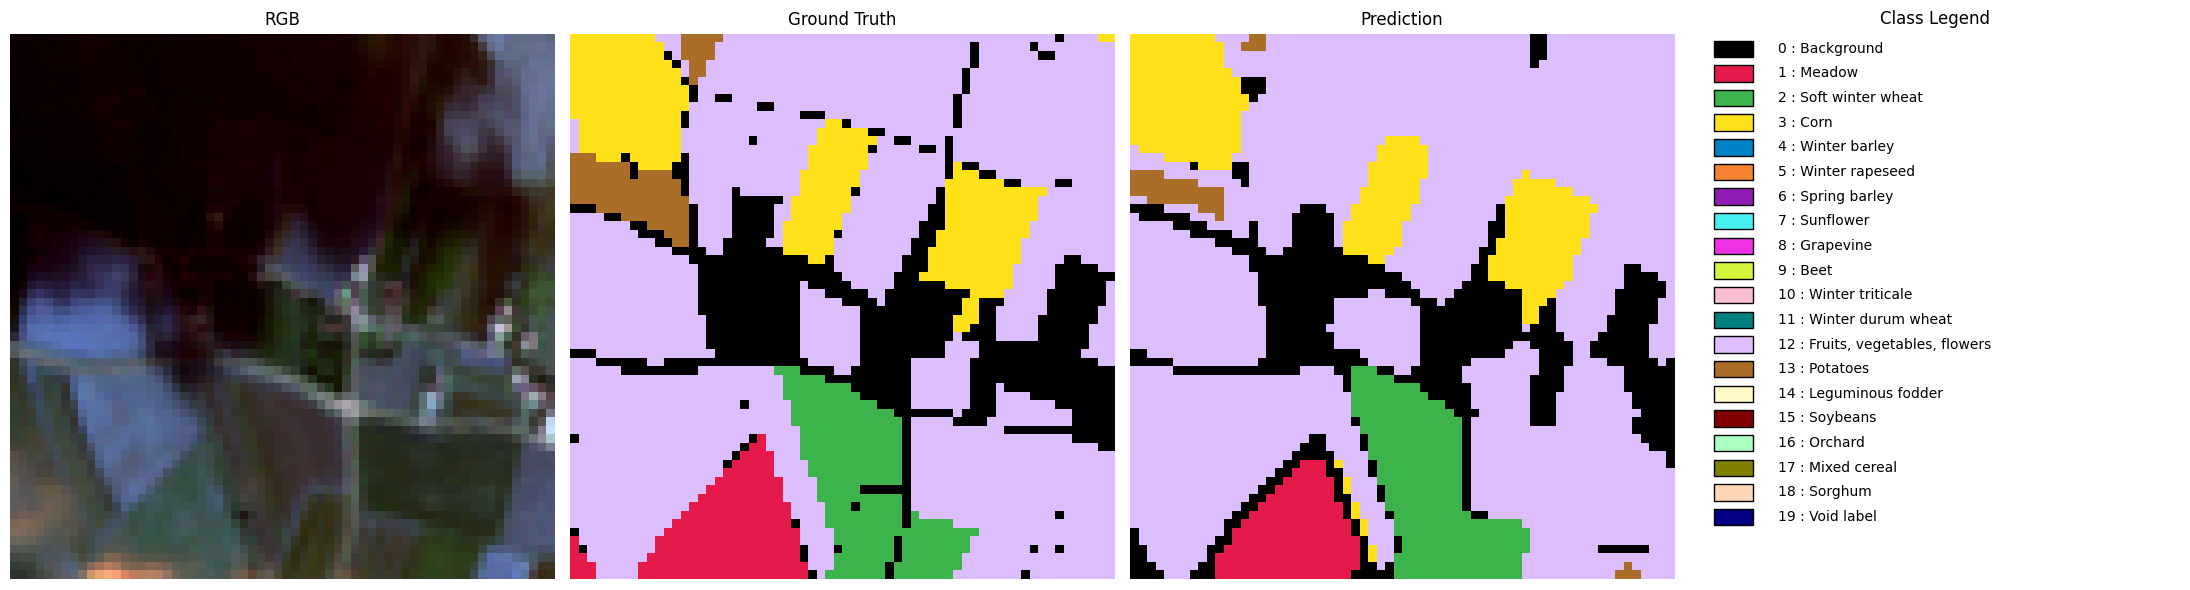

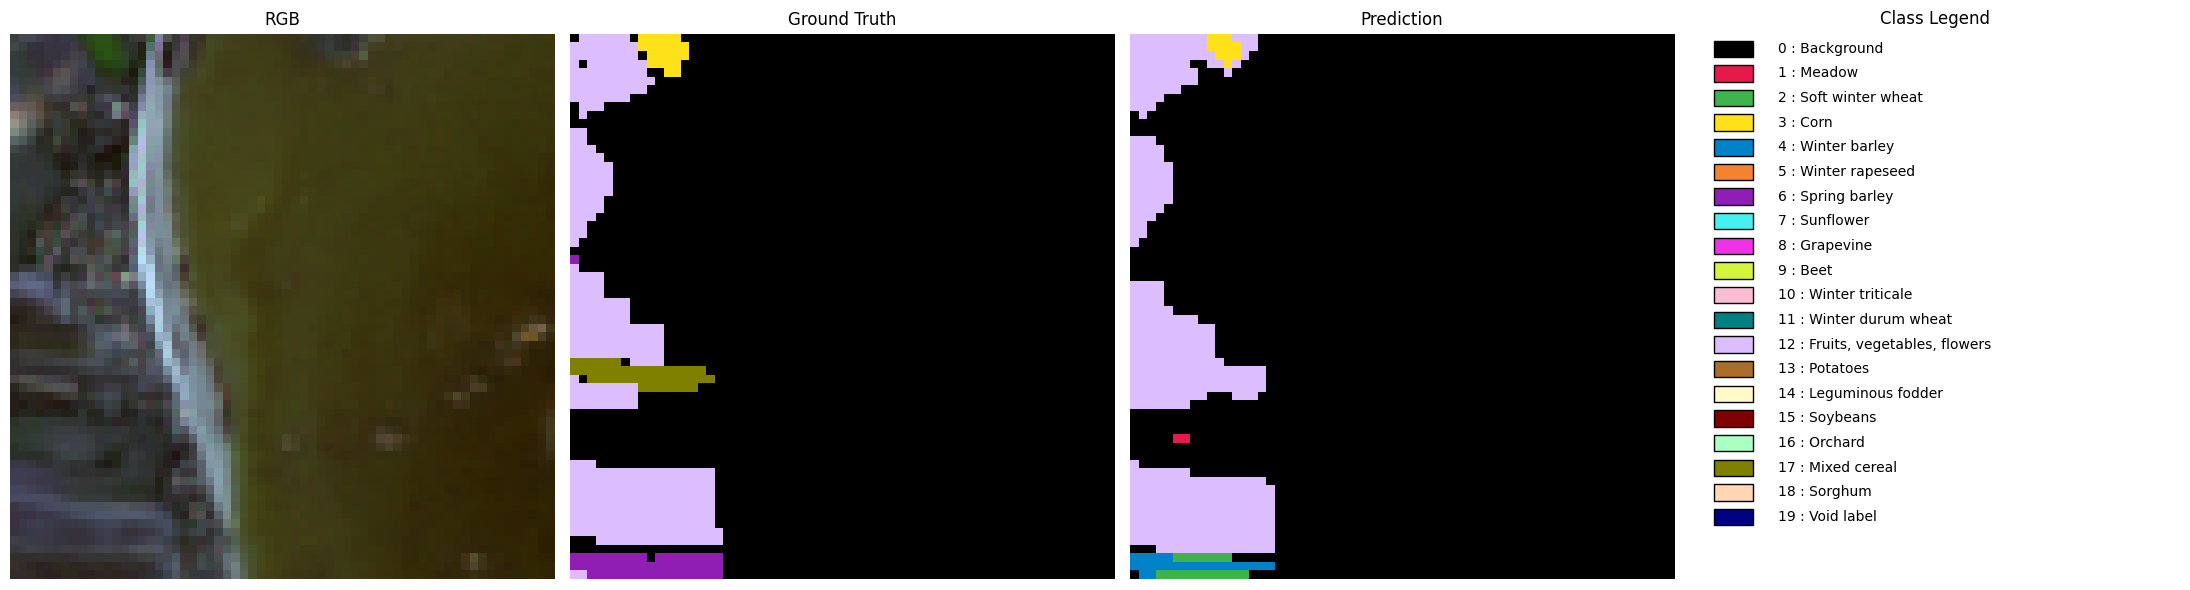

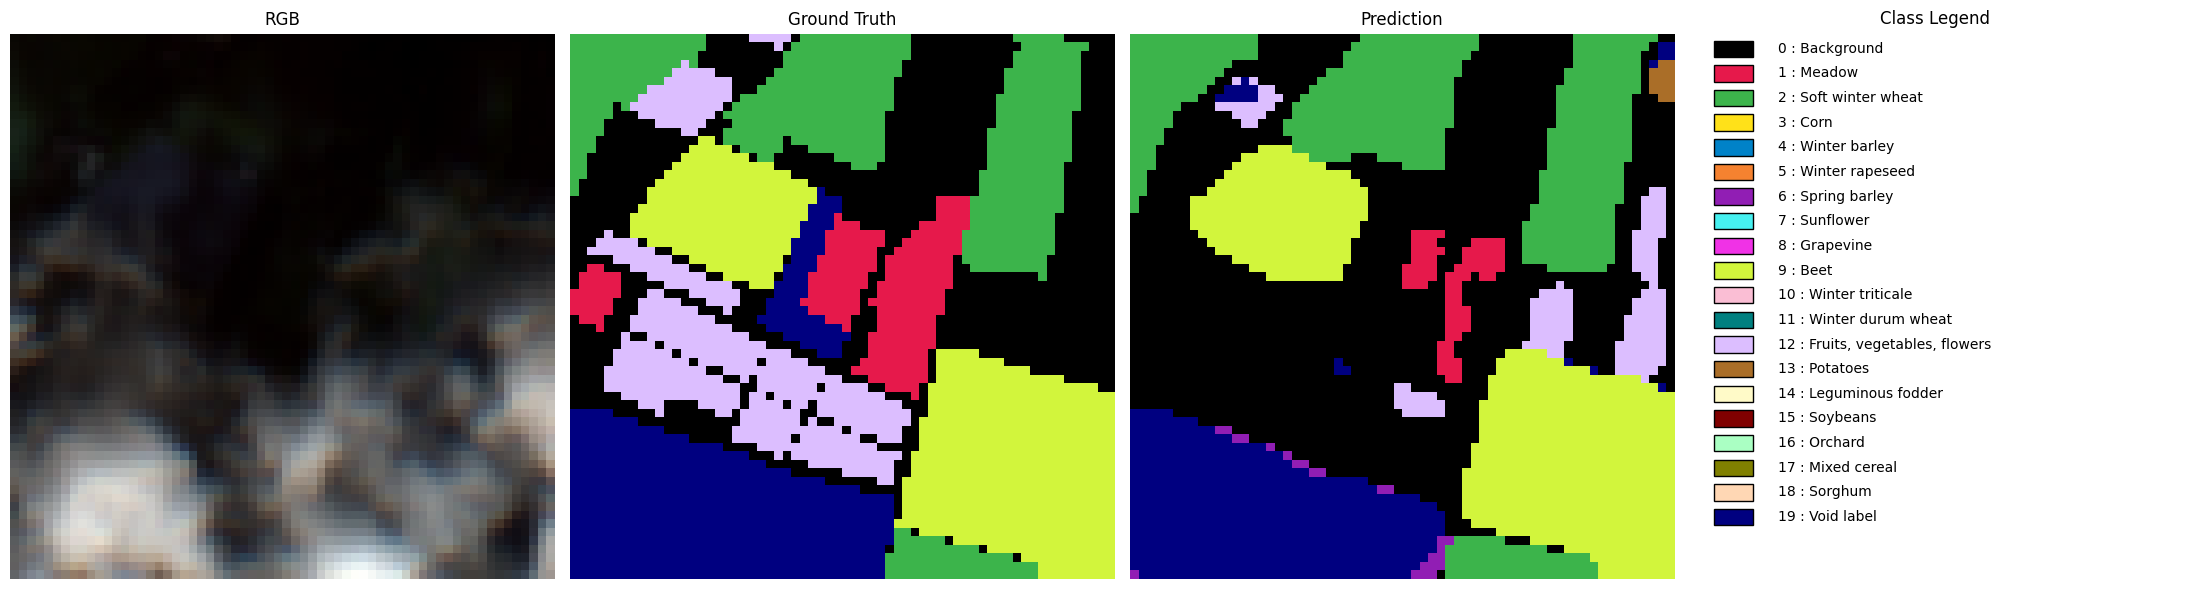

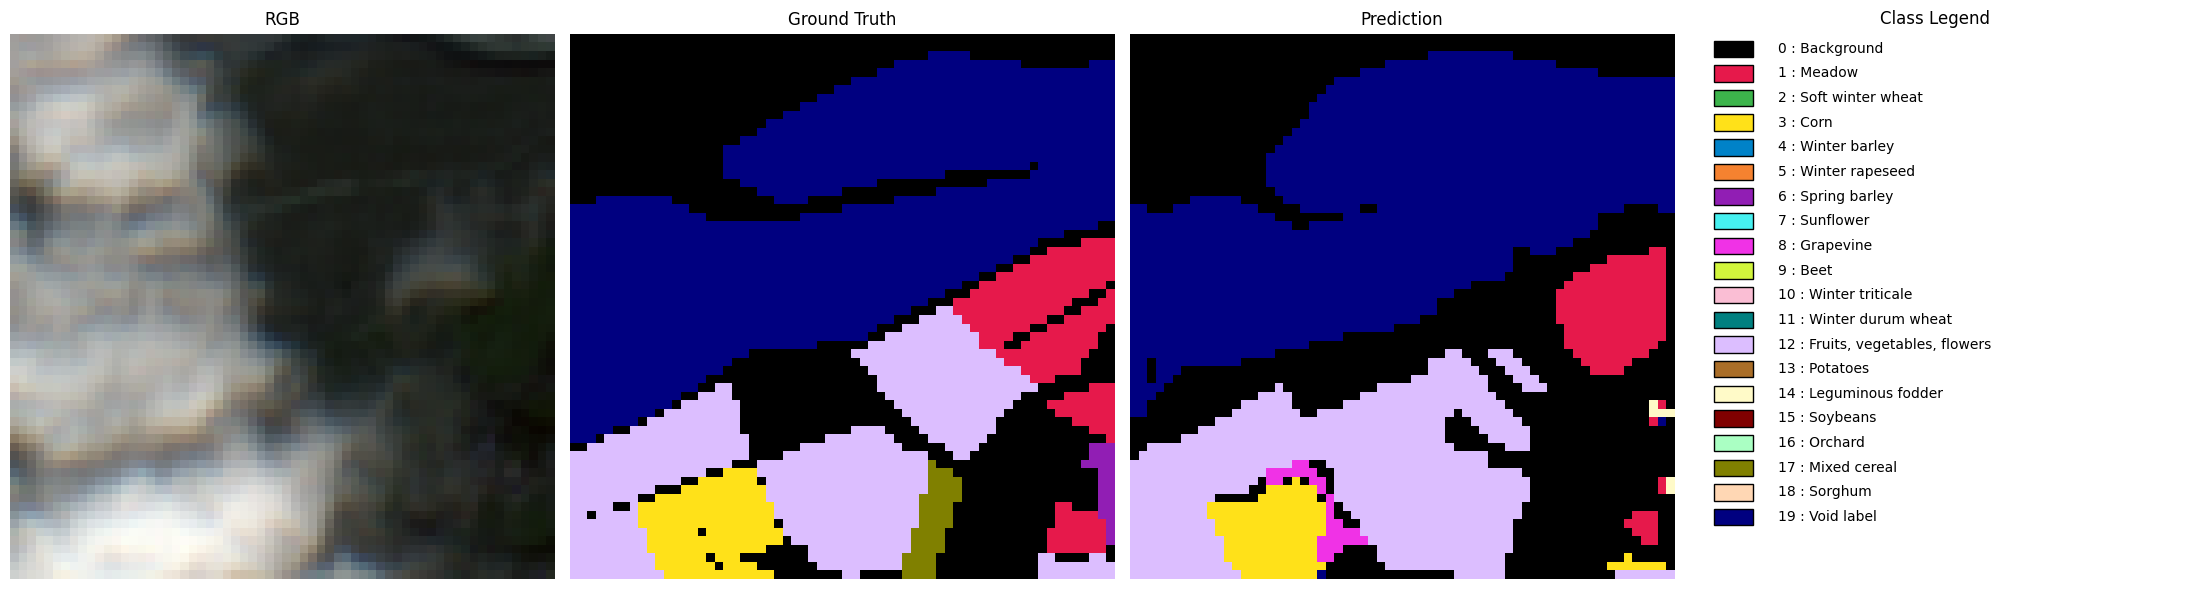

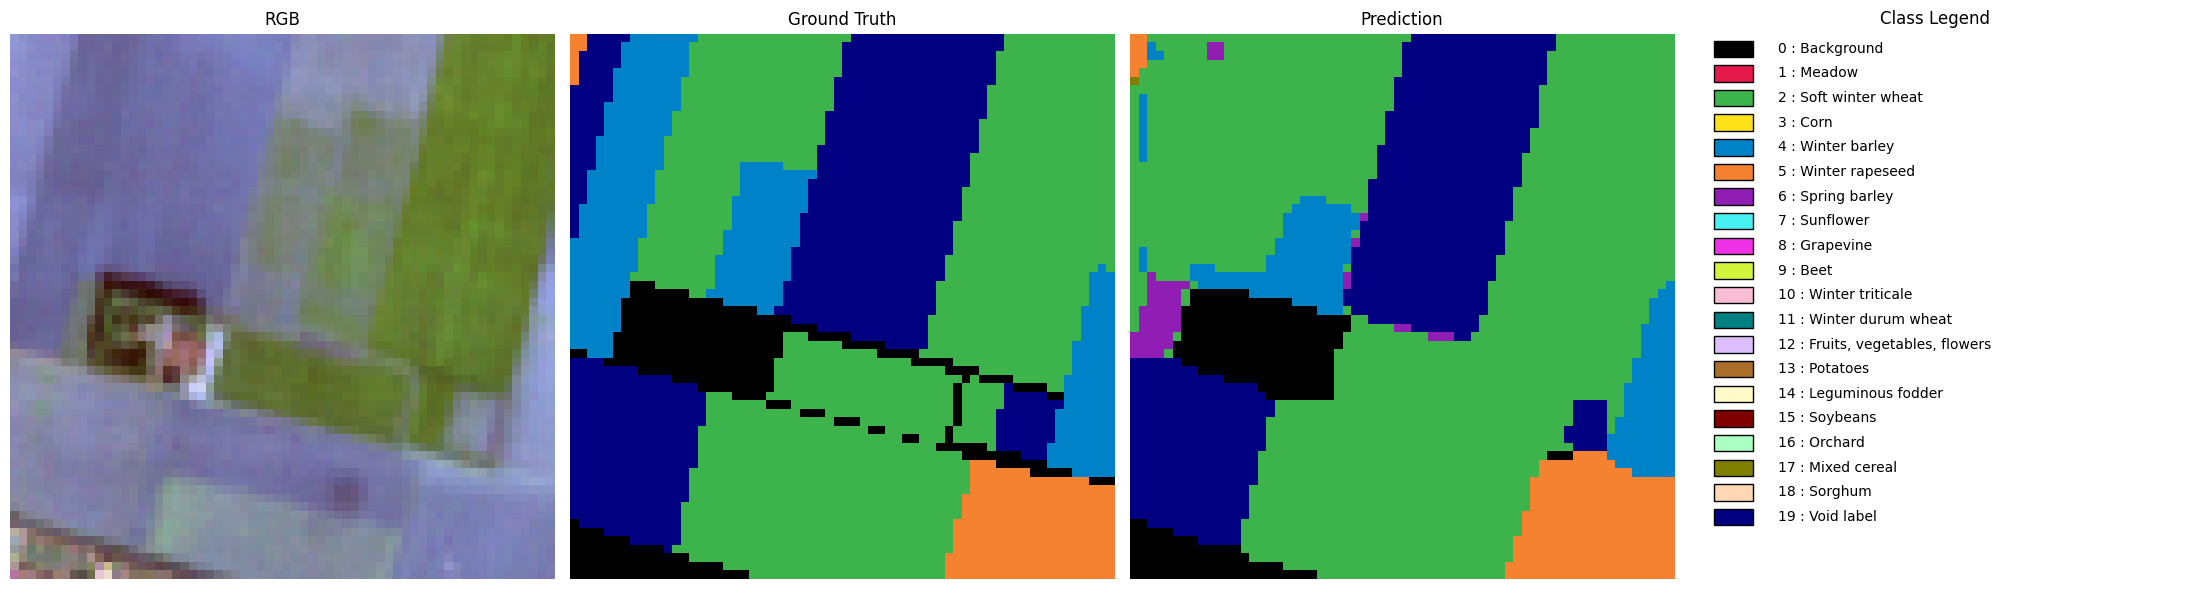

In [83]:
model.eval()

with torch.no_grad(), torch.cuda.amp.autocast():
    for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        preds = model(imgs).argmax(dim=1)
        
        visualize_with_legend(
            imgs, labels, preds,
            class_names=CLASS_NAMES,
            class_colors=CLASS_COLORS,
            sample_t=0
        )

        if i >= 4:  # visualiser 5 images max
            break


In [69]:
#Évaluation simple : Accuracy pixel-wise
def evaluate_pixel_accuracy(model, dataloader, num_classes):
    correct = 0
    total = 0

    with torch.no_grad(), torch.cuda.amp.autocast():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            labels = torch.clamp(labels, 0, num_classes - 1)

            logits = model(imgs)           # [B, C, H, W]
            preds = logits.argmax(dim=1)   # [B, H, W]

            correct += (preds == labels).sum().item()
            total += labels.numel()

    return correct / total

In [70]:
acc = evaluate_pixel_accuracy(model, test_loader, num_classes=20)
print(f"Pixel Accuracy: {acc:.4f}")


/tmp/ipykernel_55/3621772666.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Pixel Accuracy: 0.7968


In [73]:
#Calcul de la matrice de confusion pixel-wise
def compute_confusion_matrix(model, dataloader, num_classes):
    conf_mat = torch.zeros((num_classes, num_classes), dtype=torch.int64)

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            labels = torch.clamp(labels, 0, num_classes - 1)

            preds = model(imgs).argmax(dim=1)

            preds = preds.view(-1)
            labels = labels.view(-1)

            for t, p in zip(labels, preds):
                conf_mat[t.long(), p.long()] += 1

    return conf_mat


In [74]:
#Calcul OA, AA, Kappa à partir de la matrice
def oa_aa_kappa(conf_mat):
    conf_mat = conf_mat.float()
    num_classes = conf_mat.shape[0]

    # Total pixels
    N = conf_mat.sum()

    # Diagonale
    diag = torch.diag(conf_mat)

    # OA
    OA = diag.sum() / N

    # AA (mean class accuracy)
    class_acc = diag / (conf_mat.sum(dim=1) + 1e-6)
    AA = class_acc.mean()

    # Kappa
    row_sum = conf_mat.sum(dim=1)
    col_sum = conf_mat.sum(dim=0)

    pe = (row_sum * col_sum).sum() / (N * N)
    kappa = (OA - pe) / (1 - pe + 1e-6)

    return OA.item(), AA.item(), kappa.item(), class_acc


In [75]:
#Évaluation complète sur le test set
conf_mat = compute_confusion_matrix(
    model,
    test_loader,
    num_classes=20
)

OA, AA, kappa, class_acc = oa_aa_kappa(conf_mat)

print(f"Overall Accuracy (OA): {OA:.4f}")
print(f"Average Accuracy (AA): {AA:.4f}")
print(f"Kappa: {kappa:.4f}")

for i, acc in enumerate(class_acc):
    print(f"Class {i}: Accuracy = {acc:.4f}")


/tmp/ipykernel_55/3220039099.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Overall Accuracy (OA): 0.7912
Average Accuracy (AA): 0.6681
Kappa: 0.7337
Class 0: Accuracy = 0.8315
Class 1: Accuracy = 0.7762
Class 2: Accuracy = 0.9450
Class 3: Accuracy = 0.9260
Class 4: Accuracy = 0.8412
Class 5: Accuracy = 0.9064
Class 6: Accuracy = 0.4961
Class 7: Accuracy = 0.8602
Class 8: Accuracy = 0.7294
Class 9: Accuracy = 0.9498
Class 10: Accuracy = 0.1900
Class 11: Accuracy = 0.9142
Class 12: Accuracy = 0.5868
Class 13: Accuracy = 0.6768
Class 14: Accuracy = 0.6067
Class 15: Accuracy = 0.8580
Class 16: Accuracy = 0.3461
Class 17: Accuracy = 0.2511
Class 18: Accuracy = 0.3319
Class 19: Accuracy = 0.3385


In [84]:
# Architecture 2: model with sptial information -spatio_temporel_transformer-
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# 1. DATASET

class BASTISDatasetTemporal(Dataset):
    def __init__(self, img_files, label_files,
                 crop_size=(64,64),
                 sample_T=38,
                 select_C=list(range(10)),
                 mean=None, std=None):
        
        self.img_files = img_files
        self.label_files = label_files
        self.crop_size = crop_size
        self.sample_T = sample_T
        self.select_C = select_C
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):

        data = np.load(self.img_files[idx]).astype(np.float32)  # [T, C, H, W]
        labels = np.load(self.label_files[idx])                 # [T, H, W] or [H, W]

        # Use ONLY first temporal map
        if labels.ndim == 3:
            labels = labels[0]

        T, C, H, W = data.shape

        #  Temporal Sampling 
        if T >= self.sample_T:
            indices = np.linspace(0, T-1, self.sample_T)
            indices = np.round(indices).astype(int)
            data = data[indices]
        else:
            repeat_times = self.sample_T - T
            data = np.concatenate([data, np.tile(data[-1:], (repeat_times,1,1,1))], axis=0)

        # Select channels
        data = data[:, self.select_C, :, :]

        # Random Crop 
        crop_h, crop_w = self.crop_size
        h_start = random.randint(0, H - crop_h) if H > crop_h else 0
        w_start = random.randint(0, W - crop_w) if W > crop_w else 0

        data = data[:, :, h_start:h_start+crop_h, w_start:w_start+crop_w]
        labels = labels[h_start:h_start+crop_h, w_start:w_start+crop_w]

        # Normalize 
        data = data / 255.0

        if self.mean is not None and self.std is not None:
            mean = np.array(self.mean).reshape(1, len(self.select_C), 1, 1)
            std = np.array(self.std).reshape(1, len(self.select_C), 1, 1)
            data = (data - mean) / std

        labels = torch.tensor(labels, dtype=torch.long)
        return torch.tensor(data, dtype=torch.float32), labels

# 2. Compute dataset statistics (mean / std)

def compute_mean_std(img_files, select_C=list(range(10))):
    mean = np.zeros(len(select_C))
    std = np.zeros(len(select_C))
    n = 0

    print("Computing mean/std...")

    for f in img_files:
        data = np.load(f).astype(np.float32)  # [T, C, H, W]
        data = data[:, select_C, :, :] / 255.0
        T, C, H, W = data.shape
        data = data.reshape(T, C, -1)
        mean += data.mean(axis=(0, 2))
        std += data.std(axis=(0, 2))
        n += 1

    mean /= n
    std /= n
    print("Mean:", mean)
    print("Std :", std)
    return mean.tolist(), std.tolist()

# 3. Spatio-Temporal Transformer (Patch 7×7)
class SpatialPatchExtractor(nn.Module):
    """Extract local 7x7 spatial neighborhoods for each pixel."""
    def __init__(self, patch=7):
        super().__init__()
        self.patch = patch
        self.pad = patch // 2

    def forward(self, x):
        """
        x : [B, T, C, H, W]
        returns : [B, T, 49*C, H, W]
        """
        B, T, C, H, W = x.shape

        # reshape for 2D patch extraction
        x = x.reshape(B*T, C, H, W)

        # unfold → extract patches
        patches = F.unfold(x, kernel_size=self.patch, padding=self.pad)
        # reshape to [B*T, C*49, H, W]
        patches = patches.reshape(B*T, C * self.patch * self.patch, H, W)

        # reshape back to [B, T, 49*C, H, W]
        patches = patches.reshape(B, T, C * self.patch * self.patch, H, W)
        return patches



class PixelSpatioTemporalBERT(nn.Module):
    def __init__(self, in_channels=10, patch=7,
                 emb_size=128, num_heads=4, num_layers=4,
                 max_T=38, dropout=0.1):
        
        super().__init__()

        self.patch = patch
        self.ext = SpatialPatchExtractor(patch=patch)

        # embedding of local 7x7 * C channels
        self.pixel_embed = nn.Linear(in_channels * patch * patch, emb_size)

        # temporal positional embedding
        self.pos_embed = nn.Parameter(torch.randn(1, max_T, emb_size))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.emb_size = emb_size

    def forward(self, x):
        """
        x : [B, T, C, H, W]
        """
        B, T, C, H, W = x.shape

        # Extract spatial patches
        x = self.ext(x)   # → [B, T, 49*C, H, W]

        # Move pixels to batch dimension
        x = x.permute(0, 3, 4, 1, 2)  # → [B, H, W, T, 49*C]
        x = x.reshape(B*H*W, T, -1)  # → [B*H*W, T, 49*C]

        # Temporal embedding
        x = self.pixel_embed(x)
        x = x + self.pos_embed[:, :T, :]

        # Transformer
        x_encoded = self.encoder(x)

        return x_encoded, H, W, B



class PixelSpatioTemporalClassifier(PixelSpatioTemporalBERT):
    def __init__(self, num_classes, pooling='mean', **kwargs):
        super().__init__(**kwargs)
        self.pooling = pooling
        self.classifier = nn.Linear(self.emb_size, num_classes)

    def forward(self, x):
        x_encoded, H, W, B = super().forward(x)

        # pool temporal sequence
        if self.pooling == 'mean':
            x_pooled = x_encoded.mean(dim=1)
        else:
            x_pooled = x_encoded[:, -1, :]

        logits = self.classifier(x_pooled)
        logits = logits.reshape(B, H, W, -1).permute(0, 3, 1, 2)

        return logits
# 4. Dataset + Loader

mean, std = compute_mean_std(train_img_list, select_C=list(range(10)))

dataset = BASTISDatasetTemporal(
    train_img_list,
    train_mask_list,
    crop_size=(64,64),
    sample_T=38,
    select_C=list(range(10)),
    mean=mean,
    std=std 
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
# 5. Model, Loss, Optimizer

num_classes = 20

model = PixelSpatioTemporalClassifier(
    num_classes=num_classes,
    in_channels=10,
    patch=7,
    emb_size=128,
    num_heads=4,
    num_layers=4,
    max_T=38
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()
# 6. Training Loop

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    torch.cuda.empty_cache()

    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        labels = torch.clamp(labels, 0, num_classes-1)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(dataloader):.4f}")

# 7. Save Model

torch.save(model.state_dict(), "pixel_spatiotemporal_bert_7x7.pth")
print("Model saved successfully!")



# 8Inference Check


model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        print("Prediction shape:", preds.shape)
        break


Computing mean/std...
Mean: [ 4.60923348  5.42787734  5.62163625  6.93451382 10.68580974 12.03430433
 12.5850057  13.03430689  9.43758712  6.37534238]
Std : [7.72134676 7.49407892 7.81147219 7.44582023 6.98527348 7.04188839
 7.10651243 7.03611706 5.80471135 5.15914594]


/tmp/ipykernel_55/2223096315.py:227: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_55/2223096315.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Loss: 1.8179
Epoch 2/30 | Loss: 1.3366
Epoch 3/30 | Loss: 1.2095
Epoch 4/30 | Loss: 1.0983
Epoch 5/30 | Loss: 1.0452
Epoch 6/30 | Loss: 1.0030
Epoch 7/30 | Loss: 0.9443
Epoch 8/30 | Loss: 0.9210
Epoch 9/30 | Loss: 0.9105
Epoch 10/30 | Loss: 0.8704
Epoch 11/30 | Loss: 0.8676
Epoch 12/30 | Loss: 0.8328
Epoch 13/30 | Loss: 0.8382
Epoch 14/30 | Loss: 0.8249
Epoch 15/30 | Loss: 0.7787
Epoch 16/30 | Loss: 0.7773
Epoch 17/30 | Loss: 0.7786
Epoch 18/30 | Loss: 0.7621
Epoch 19/30 | Loss: 0.7484
Epoch 20/30 | Loss: 0.7496
Epoch 21/30 | Loss: 0.7387
Epoch 22/30 | Loss: 0.7129
Epoch 23/30 | Loss: 0.7129
Epoch 24/30 | Loss: 0.6972
Epoch 25/30 | Loss: 0.7003
Epoch 26/30 | Loss: 0.6987
Epoch 27/30 | Loss: 0.6756
Epoch 28/30 | Loss: 0.6621
Epoch 29/30 | Loss: 0.6634
Epoch 30/30 | Loss: 0.6639
Model saved successfully!
Prediction shape: torch.Size([1, 64, 64])


/tmp/ipykernel_55/2223096315.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


In [77]:
# charger  le modéle 
import torch
import torch.nn as nn

model = PixelSpatioTemporalClassifier(
    num_classes=20,   
    in_channels=10,   
    patch=7,
    emb_size=128,
    num_heads=4,
    num_layers=4,
    max_T=38
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load("pixel_spatiotemporal_bert_7x7.pth", map_location=device))
model.to(device)
model.eval()


PixelSpatioTemporalClassifier(
  (ext): SpatialPatchExtractor()
  (pixel_embed): Linear(in_features=490, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=20, bias=True)
)

/tmp/ipykernel_55/1300819150.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


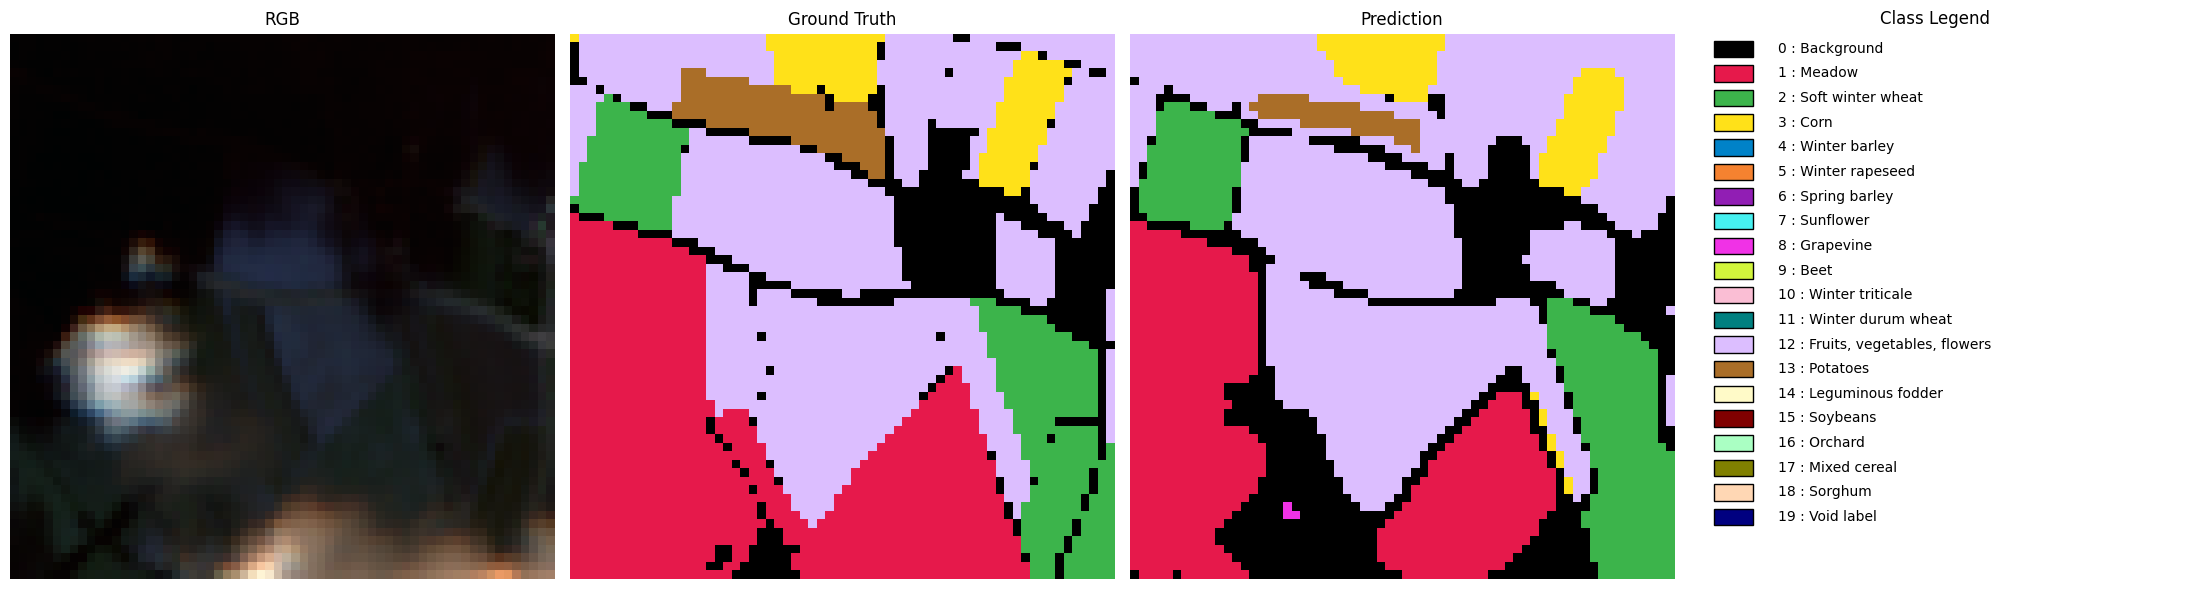

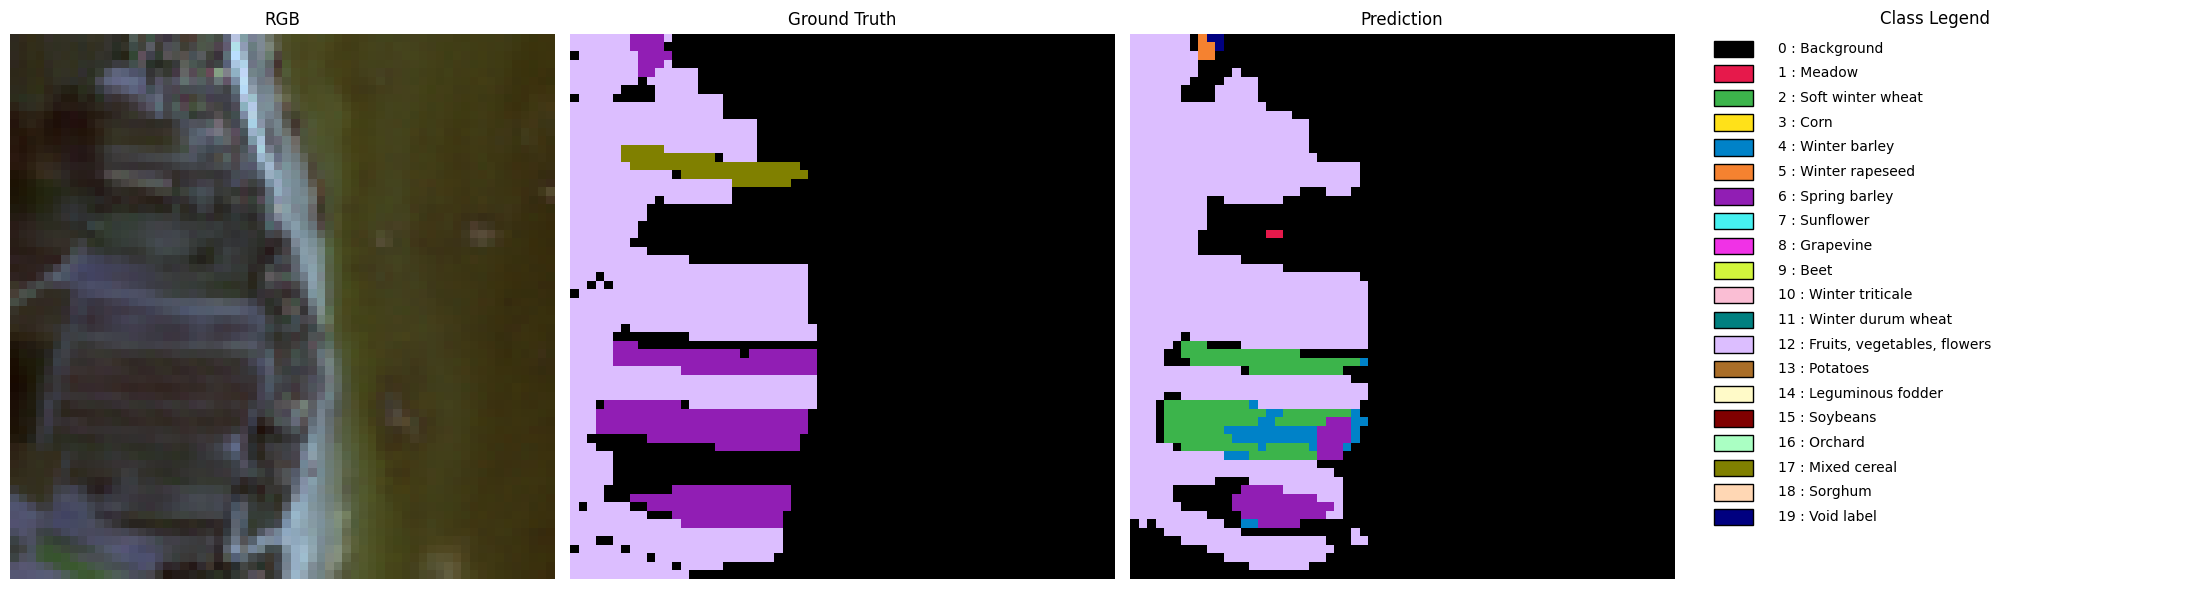

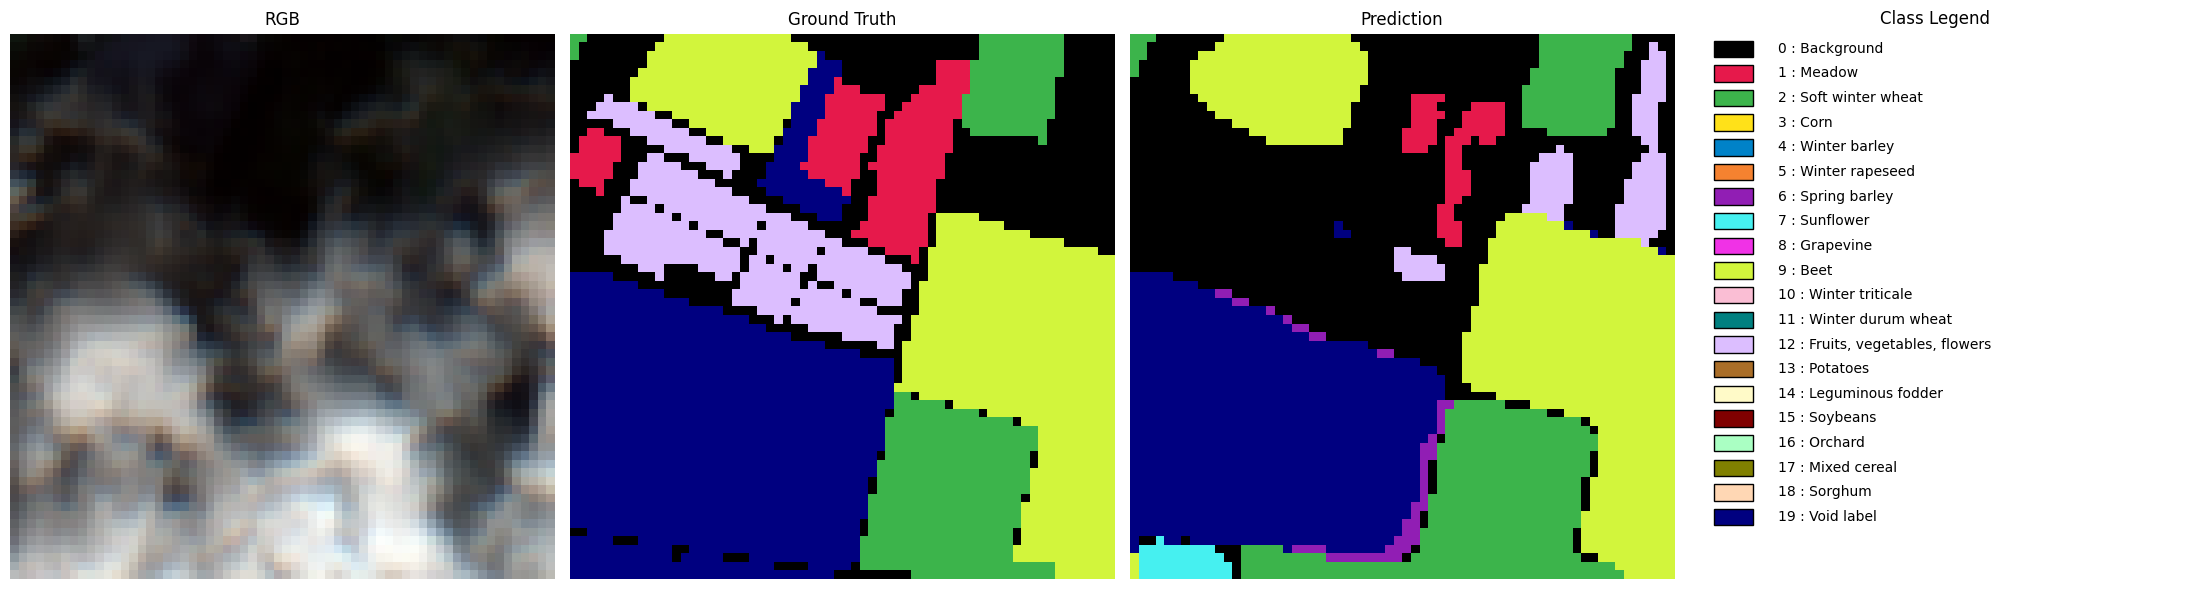

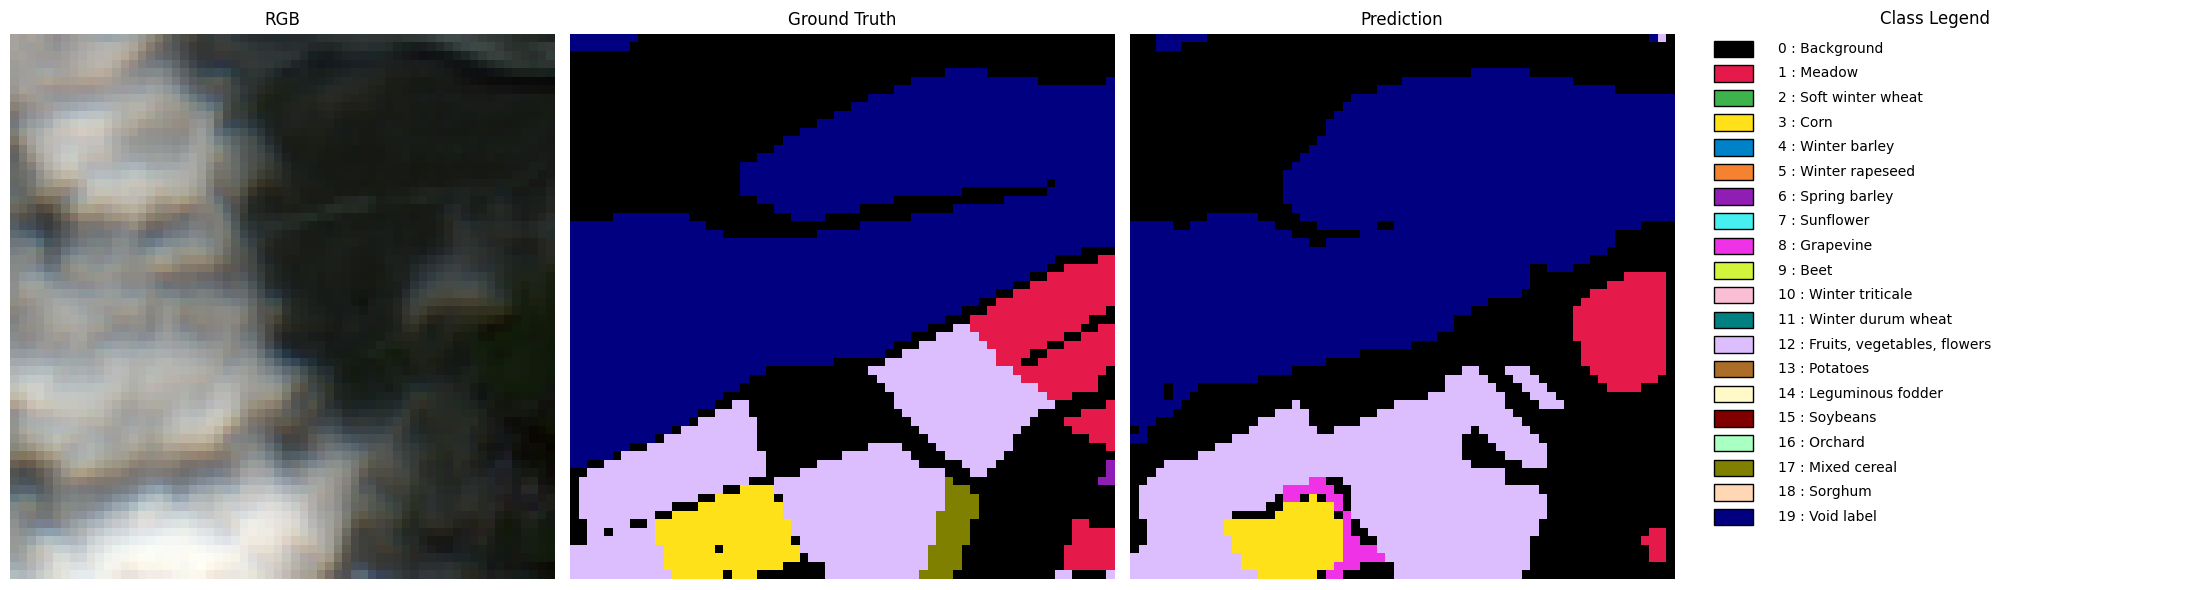

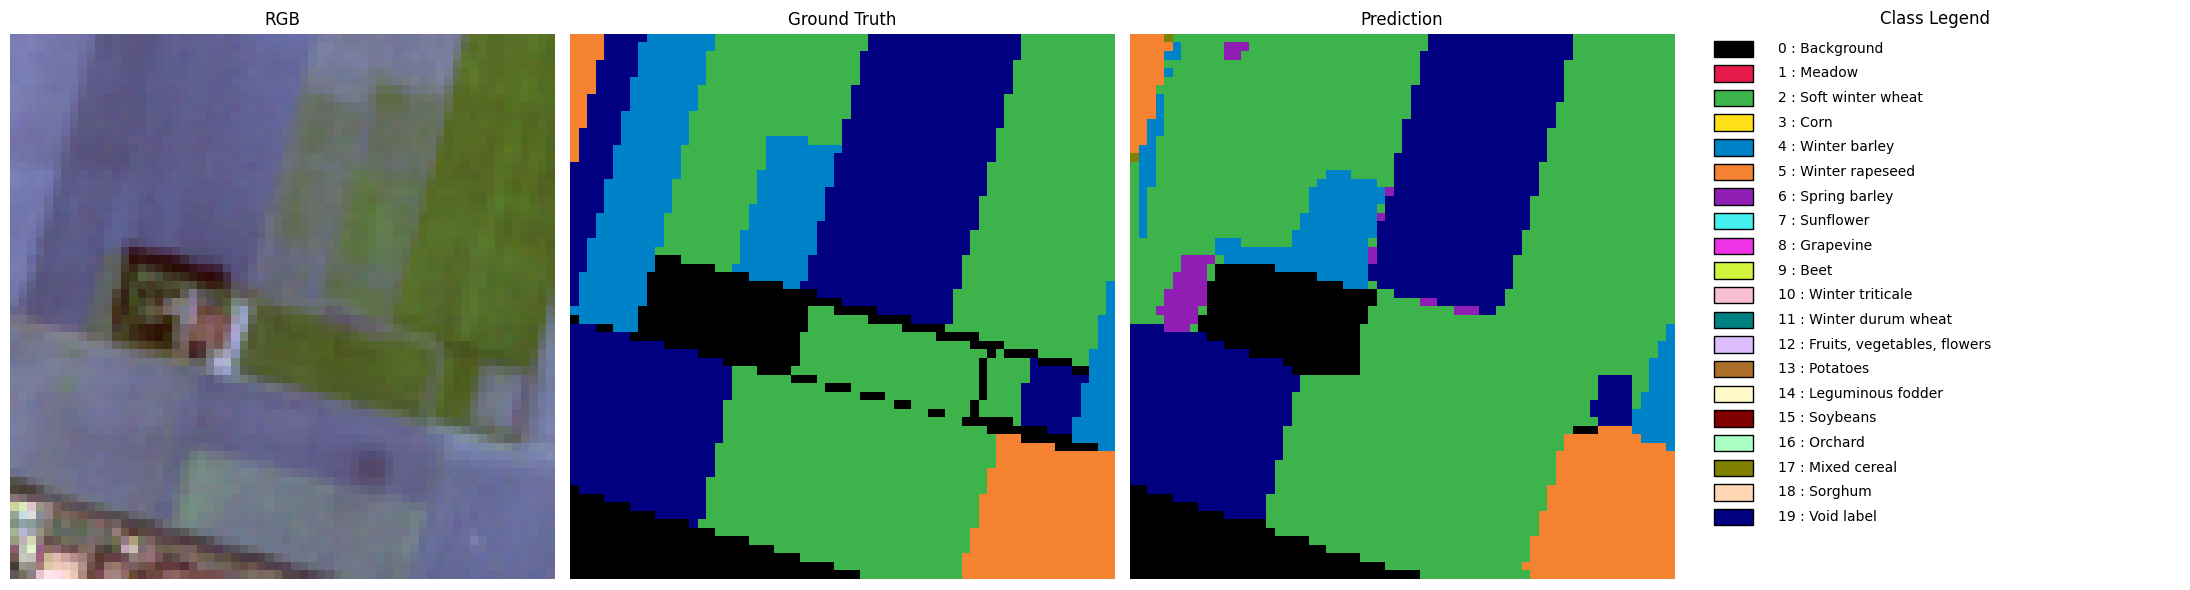

In [78]:
model.eval()

with torch.no_grad(), torch.cuda.amp.autocast():
    for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        preds = model(imgs).argmax(dim=1)
        
        visualize_with_legend(
            imgs, labels, preds,
            class_names=CLASS_NAMES,
            class_colors=CLASS_COLORS,
            sample_t=0
        )

        if i >= 4:  
            break


In [79]:
acc = evaluate_pixel_accuracy(model, test_loader, num_classes=20)
print(f"Pixel Accuracy: {acc:.4f}")


/tmp/ipykernel_55/3621772666.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Pixel Accuracy: 0.7934


In [82]:
#Évaluation complète sur le test set
conf_mat = compute_confusion_matrix(
    model,
    test_loader,
    num_classes=20
)

OA, AA, kappa, class_acc = oa_aa_kappa(conf_mat)

print(f"Overall Accuracy (OA): {OA:.4f}")
print(f"Average Accuracy (AA): {AA:.4f}")
print(f"Kappa: {kappa:.4f}")

for i, acc in enumerate(class_acc):
    print(f"Class {i}: Accuracy = {acc:.4f}")


/tmp/ipykernel_55/3220039099.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Overall Accuracy (OA): 0.7927
Average Accuracy (AA): 0.6625
Kappa: 0.7361
Class 0: Accuracy = 0.8346
Class 1: Accuracy = 0.7897
Class 2: Accuracy = 0.9354
Class 3: Accuracy = 0.9328
Class 4: Accuracy = 0.8400
Class 5: Accuracy = 0.9227
Class 6: Accuracy = 0.4082
Class 7: Accuracy = 0.8097
Class 8: Accuracy = 0.7253
Class 9: Accuracy = 0.9457
Class 10: Accuracy = 0.1816
Class 11: Accuracy = 0.9312
Class 12: Accuracy = 0.5667
Class 13: Accuracy = 0.7146
Class 14: Accuracy = 0.5425
Class 15: Accuracy = 0.8768
Class 16: Accuracy = 0.4072
Class 17: Accuracy = 0.2515
Class 18: Accuracy = 0.2642
Class 19: Accuracy = 0.3690
